In [1]:
%config IPCompleter.greedy=True
import numpy as np
import pandas as pd

# Read dataset off Github
hs_2017 = pd.read_csv("hs_2017.csv")

# creating categorical variable from existing column - https://stackoverflow.com/a/49269107
# ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] < 1080,'sat_high_level'] = 0
# ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] >= 1080,'sat_high_level'] = 1

# subsetting to remove rows where no average SAT score was reported
# ml_hs_2017 = ml_hs_2017_all.loc[ml_hs_2017_all['sat_avg_score_num'] >0]

In [34]:
# zero_counts = []
#for column in ml_hs_2017:
#    zero_counts.append({'Column': column, 'count': np.sum((ml_hs_2017[column]==0)), 'Percentage': np.sum((ml_hs_2017[column]==0)/len(ml_hs_2017))})

In [35]:
# zero_counts = pd.DataFrame(zero_counts)
# to_drop = zero_counts.loc[zero_counts['Percentage'] >= .999]
# hs_2017 = ml_hs_2017.drop(to_drop['Column'], axis=1)
# hs_2017.info()

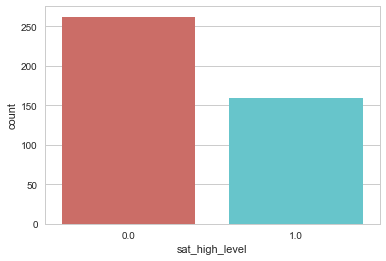

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x='sat_high_level',data=hs_2017, palette='hls')
plt.show()

In [4]:
Y_sat_high=hs_2017['sat_high_level'].values
Y = Y_sat_high
del hs_2017['sat_high_level']
X_highSchools=hs_2017# remove .values if necessary

In [5]:
#Divide data into test and training splits
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)

In [6]:
from sklearn.model_selection import cross_validate

def EvaluateClassifierEstimator(classifierEstimator, X, y, cv):
   
    #Perform cross validation 
    scores = cross_validate(classifierEstimator, X_highSchools, Y, scoring=['accuracy','precision','recall']
                            , cv=cv, return_train_score=True)

    Accavg = scores['test_accuracy'].mean()
    Preavg = scores['test_precision'].mean()
    Recavg = scores['test_recall'].mean()

    print_str = "The average accuracy for all cv folds is: \t\t\t {Accavg:.5}"
    print_str2 = "The average precision for all cv folds is: \t\t\t {Preavg:.5}"
    print_str3 = "The average recall for all cv folds is: \t\t\t {Recavg:.5}"

    print(print_str.format(Accavg=Accavg))
    print(print_str2.format(Preavg=Preavg))
    print(print_str3.format(Recavg=Recavg))
    print('*********************************************************')

    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    scoresResults['Accuracy'] = scores['test_accuracy']
    scoresResults['Precision'] = scores['test_precision']
    scoresResults['Recall'] = scores['test_recall']

    return scoresResults

def EvaluateClassifierEstimator2(classifierEstimator, X, y, cv):
    
    #Perform cross validation 
    from sklearn.model_selection import cross_val_predict
    predictions = cross_val_predict(classifierEstimator, X_highSchools, Y, cv=cv)
    
    #model evaluation 
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    
    #pass true test set values and predictions to classification_report
    classReport = classification_report(Y,predictions)
    confMat = confusion_matrix(Y,predictions)
    acc = accuracy_score(Y,predictions)
    
    print(classReport)
    print(confMat)
    print(acc)


In [8]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced', 'none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=4 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools, Y)

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   13.1s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   18.7s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [9]:
#Diplay the top model parameters

regGridSearch.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [10]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools, Y, cv)


The average accuracy for all cv folds is: 			 0.86471
The average precision for all cv folds is: 			 0.80187
The average recall for all cv folds is: 			 0.85755
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.882353,0.928571,0.764706
1,0.929412,0.916667,0.916667
2,0.847059,0.790698,0.894737
3,0.788235,0.702703,0.787879
4,0.811765,0.676471,0.821429
5,0.800000,0.714286,0.781250
6,0.905882,0.804878,1.000000
7,0.929412,0.885714,0.939394
8,0.847059,0.838710,0.764706
9,0.905882,0.760000,0.904762


In [11]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools, Y, 10)


             precision    recall  f1-score   support

        0.0       0.89      0.85      0.87       262
        1.0       0.77      0.83      0.80       159

avg / total       0.85      0.84      0.84       421

[[223  39]
 [ 27 132]]
0.8432304038004751


In [12]:
# Scale dataset converting to standard normally distributed data 
# (e.g. Gaussian with 0 mean and unit variance).
from sklearn.preprocessing import StandardScaler

#Fit to data for scaling
scaler = StandardScaler()
scaler.fit(X_highSchools)

#Transform training data to z-scores
#This makes our model's coefficients take on the same scale for accurate feature importance analasys 
X_highSchools_Scl = scaler.transform(X_highSchools)

In [13]:
#Logisitic regression 10-fold cross-validation 
from sklearn.linear_model import LogisticRegression
regEstimator = LogisticRegression()


parameters = { 'penalty':['l2']
              ,'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'class_weight': ['balanced','none']
              ,'random_state': [0]
              ,'solver': ['lbfgs']
              ,'max_iter':[100,500]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=regEstimator
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring='accuracy')

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_highSchools_Scl, Y)


Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 265 out of 280 | elapsed:    6.4s remaining:    0.3s
[Parallel(n_jobs=8)]: Done 280 out of 280 | elapsed:    6.4s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': ['balanced', 'none'], 'random_state': [0], 'solver': ['lbfgs'], 'max_iter': [100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [14]:
#Display the best estimator parameters
regGridSearch.best_estimator_

LogisticRegression(C=1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [15]:
#Use the best parameters for our Linear Regression object
classifierEst = regGridSearch.best_estimator_

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics. 
EvaluateClassifierEstimator(classifierEst, X_highSchools_Scl, Y, cv)


The average accuracy for all cv folds is: 			 0.84941
The average precision for all cv folds is: 			 0.80201
The average recall for all cv folds is: 			 0.80701
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.835294,0.884615,0.676471
1,0.905882,0.937500,0.833333
2,0.788235,0.750000,0.789474
3,0.823529,0.750000,0.818182
4,0.811765,0.676471,0.821429
5,0.823529,0.774194,0.750000
6,0.894118,0.833333,0.909091
7,0.905882,0.857143,0.909091
8,0.800000,0.774194,0.705882
9,0.905882,0.782609,0.857143


In [16]:
EvaluateClassifierEstimator2(classifierEst, X_highSchools_Scl, Y, 10)

             precision    recall  f1-score   support

        0.0       0.88      0.86      0.87       262
        1.0       0.78      0.80      0.79       159

avg / total       0.84      0.84      0.84       421

[[226  36]
 [ 32 127]]
0.838479809976247


In [17]:
from sklearn.feature_selection import RFECV

#Create a regression estimator with best parameters for cross validation
classifierEst = regGridSearch.best_estimator_

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
rfecv.fit(X_highSchools, Y)

RFECV(cv=ShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=None),
   estimator=LogisticRegression(C=1, class_weight='none', dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False),
   n_jobs=1, scoring='accuracy', step=1, verbose=0)

Optimal number of features : 159


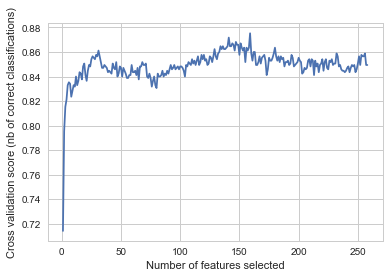

In [18]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt
%matplotlib inline

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [19]:
#Plot the RFE Rankings
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':X_highSchools.columns, 'weights':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='weights', inplace=True, ascending=False )

top50features = rfe_ft_imp_df.head(50)

top50features

,feature_names,weights
158,lea_avg_student_num,0.875294
140,EOCMathI_CACR_TwoorMoreRaces,0.871765
146,ACTCompositeScore_UNCMin_Hispanic,0.868235
150,ACTWriting_ACTBenchmark_TwoorMoreRaces,0.867059
143,ACTWriting_ACTBenchmark_SWD,0.867059
144,ACTWorkKeys_SilverPlus_Black,0.865882
148,SPG Grade_A+NG,0.865882
147,EOCBiology_CACR_AIG,0.865882
133,EOCSubjects_CACR_AIG,0.864706
141,lea_1yr_tchr_trnovr_pct,0.864706


In [20]:
X_highSchools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Columns: 258 entries, Unnamed: 0 to EOCBiology_CACR_Black
dtypes: float64(238), int64(20)
memory usage: 848.7 KB


In [28]:
X_highSchools=pd.DataFrame(X_highSchools)

In [21]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit

#Use recursive feature elimination to get the best features for our model
#(We already did this earlier, but I am including it again below in comment for a complete example!)

rfecv = RFECV(estimator=classifierEst, step=1, cv=cv, scoring='accuracy')
X_BestFeatures = rfecv.fit_transform(X_highSchools, Y)

#create a pipeline to scale all of the data and perform logistic regression during each grid search step.
pipe = make_pipeline(StandardScaler(), LogisticRegression())

# Define a range of hyper parameters for grid search
parameters = { 'logisticregression__penalty':['l2']
              ,'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
              ,'logisticregression__class_weight': ['balanced','none']
              ,'logisticregression__random_state': [0]
              ,'logisticregression__solver': ['lbfgs']
              ,'logisticregression__max_iter':[100,500]
             }

#Perform the grid search using accuracy as a metric during cross validation.
grid = GridSearchCV(pipe, parameters, cv=cv, scoring='accuracy')

#Use the best features from recursive feature elimination during the grid search
grid.fit(X_BestFeatures, Y)

#display the best pipeline model identified during the grid search
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False))])

In [22]:
EvaluateClassifierEstimator(grid.best_estimator_, X_BestFeatures, Y, cv)

The average accuracy for all cv folds is: 			 0.87647
The average precision for all cv folds is: 			 0.813
The average recall for all cv folds is: 			 0.87507
*********************************************************
Cross Validation Fold Mean Error Scores


,Accuracy,Precision,Recall
0,0.894118,0.857143,0.882353
1,0.870588,0.837838,0.861111
2,0.858824,0.809524,0.894737
3,0.800000,0.700000,0.848485
4,0.858824,0.785714,0.785714
5,0.858824,0.833333,0.781250
6,0.917647,0.842105,0.969697
7,0.941176,0.888889,0.969697
8,0.847059,0.783784,0.852941
9,0.917647,0.791667,0.904762


In [23]:
EvaluateClassifierEstimator2(grid.best_estimator_, X_BestFeatures, Y, 10)

             precision    recall  f1-score   support

        0.0       0.92      0.88      0.90       262
        1.0       0.82      0.87      0.84       159

avg / total       0.88      0.88      0.88       421

[[231  31]
 [ 20 139]]
0.8788598574821853


In [24]:
X_highSchools=pd.DataFrame(X_highSchools) # casting as dataframe for column interpretation

#Load the model's coefficient weights and feature names into a dataframe sorted by weights
weights = grid.best_estimator_.named_steps['logisticregression'].coef_.ravel()
feature_names = X_highSchools.columns.values[rfecv.get_support(indices=True)]

linreg_ft_imp_df = pd.DataFrame({'feature_names':feature_names, 'weights':weights, 'absolute_weights': np.abs(weights)})
linreg_ft_imp_df.sort_values(by='absolute_weights', inplace=True, ascending=False)

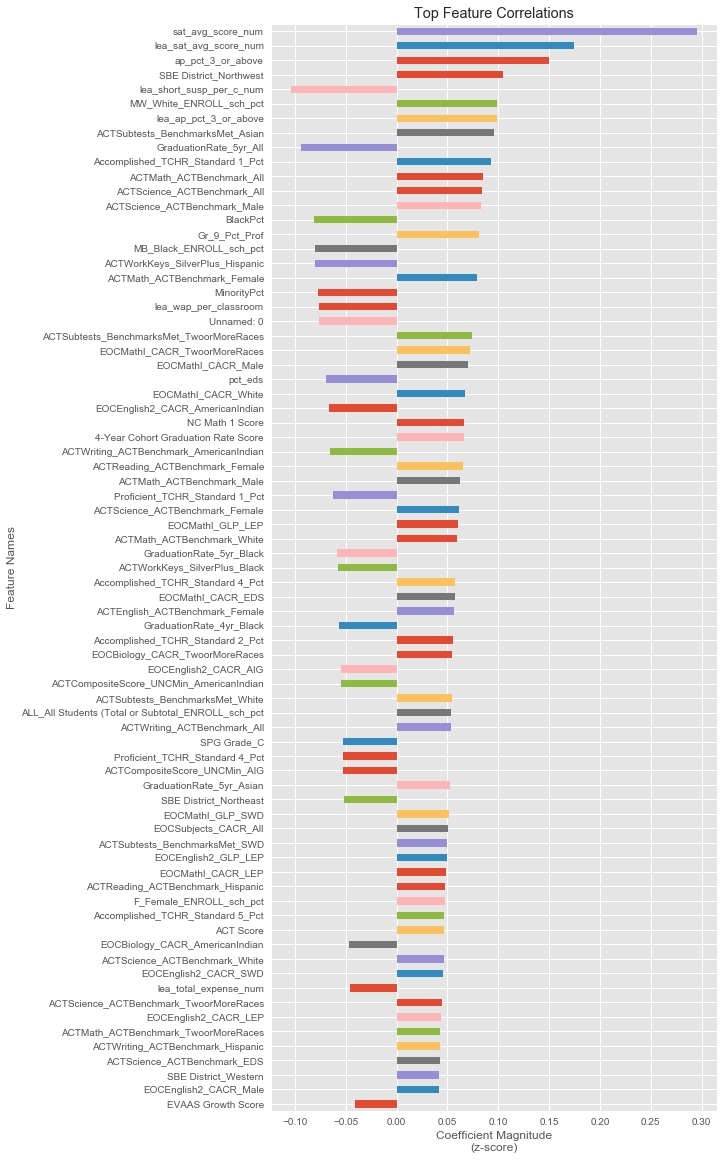

In [25]:
# Examine categorical variables of interest  
import matplotlib.pyplot as plt

%matplotlib inline

#Plot the model's feature importances
# REFERENCE:  Eric Larson, https://github.com/eclarson/DataMiningNotebooks
plt.style.use('ggplot')

wt_plt_df = linreg_ft_imp_df.head(75) # obtains the 75 most highly-weighted attributes
wt_plt_df = pd.DataFrame(wt_plt_df)
wt_plt_df.sort_values(by='absolute_weights', inplace=True, ascending=True) # reverses the sorting

weights = pd.Series(wt_plt_df['weights'].values,index=wt_plt_df['feature_names'])
ax = weights.plot(kind='barh', figsize=(8,20))

ax.set_title("Top Feature Correlations")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")

plt.show()

In [26]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

X_highSchools=hs_2017.values # re-instantiating X to get values f

for train_indices, test_indices in cv.split(X_highSchools,Y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X_highSchools[train_indices]
    y_train = Y[train_indices]
    
    X_test = X_highSchools[test_indices]
    y_test = Y[test_indices]
    
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [27]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8941176470588236
[[58  6]
 [ 3 18]]


In [28]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(208, 258)
(208,)
[104 104]


In [30]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
df_tested_on = hs_2017.loc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.loc[svm_clf.support_,:]

df_support['sat_high_level'] = Y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
hs_2017['sat_high_level'] = Y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208 entries, 4 to 334
Columns: 259 entries, Unnamed: 0 to sat_high_level
dtypes: float64(259)
memory usage: 422.5 KB


C:\Users\jeffw\Anaconda3\envs\MSDS7331\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


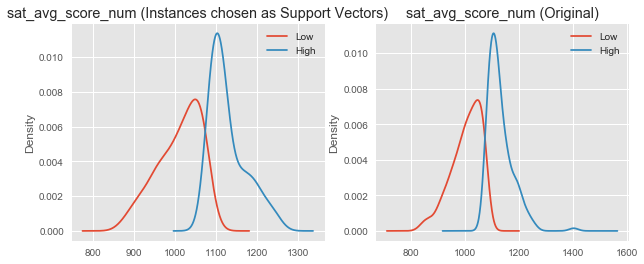

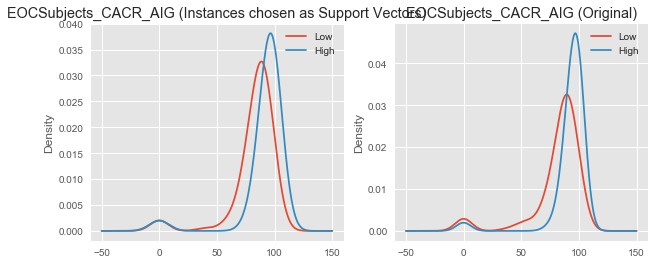

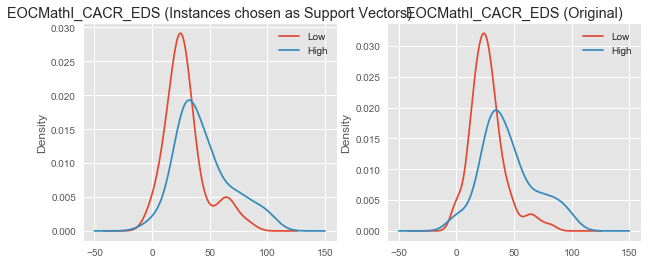

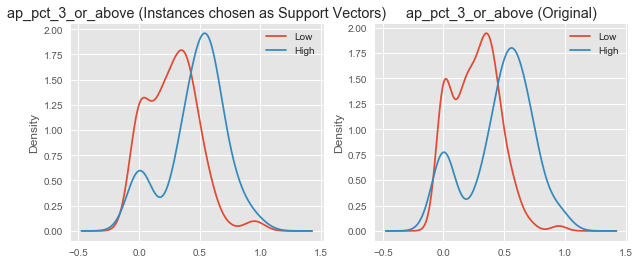

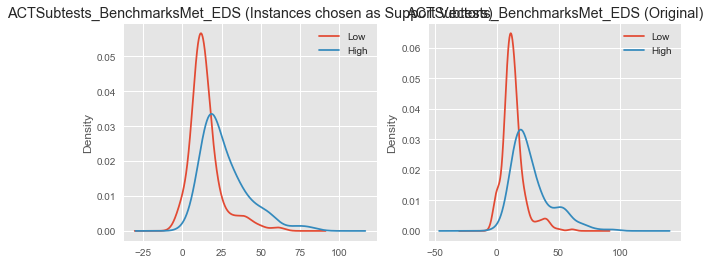

In [31]:
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['sat_high_level'])
df_grouped = hs_2017.groupby(['sat_high_level'])

# plot KDE of Different variables
vars_to_plot = ['sat_avg_score_num','EOCSubjects_CACR_AIG', 'EOCMathI_CACR_EDS', 'ap_pct_3_or_above', 'ACTSubtests_BenchmarksMet_EDS']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['Low','High'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['Low','High'])
    plt.title(v+' (Original)')